In [1]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import json

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
 

In [2]:
# Carregar os dados limpos e preparados
df = pd.read_csv('dados_modelagem.csv')

# Visualizar estrutura
df.head()


,Renda_Total,log_renda,Sexo,Cor_Raca,UF,Escolaridade_Num,Escolaridade_Label,Idade,Setor_Economico,Area_Atuacao,Faixa_Etaria
0,20.0,3.044522,Feminino,Branca,Rondônia,NaN,NaN,26,Desconhecido,Comércio,26-35
1,2121160.0,14.567474,Masculino,Parda,Rondônia,7.0,Médio completo,60,Desconhecido,Administração Pública,46-60
2,2121122.0,14.567456,Masculino,Parda,Rondônia,7.0,Médio completo,56,Desconhecido,NaN,46-60
3,1140.0,7.039660,Feminino,Preta,Rondônia,NaN,NaN,45,Desconhecido,Serviços,36-45
4,1150.0,7.048386,Feminino,Parda,Rondônia,12.0,Doutorado incompleto,28,Desconhecido,Serviços,26-35


In [3]:
# Codificar variáveis categóricas
cat_cols = ['Sexo', 'Cor_Raca', 'UF', 'Setor_Economico', 'Area_Atuacao', 'Faixa_Etaria']

# Label encoding para simplificação (pode usar OneHot depois)
le = LabelEncoder()
for col in cat_cols:
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])


In [4]:
# Features (variáveis independentes)
X = df[['Idade', 'Escolaridade_Num', 'Sexo', 'Cor_Raca', 'UF', 'Area_Atuacao']]

# Target (variável dependente que queremos prever)
y = df['log_renda']

# Preencher valores nulos, se houver
X['Escolaridade_Num'] = X['Escolaridade_Num'].fillna(X['Escolaridade_Num'].mean())


/tmp/ipykernel_36428/2492548643.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Escolaridade_Num'] = X['Escolaridade_Num'].fillna(X['Escolaridade_Num'].mean())


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)
y_pred = modelo_lr.predict(X_test)

print("R² (Linear Regression):", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² (Linear Regression): 0.13081159352690597
RMSE: 4.097939755080107


In [7]:
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

print("R² (Random Forest):", r2_score(y_test, y_pred_rf))
print("RMSE (Random Forest):", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


R² (Random Forest): 0.2806204594941044
RMSE (Random Forest): 3.7281008152817985


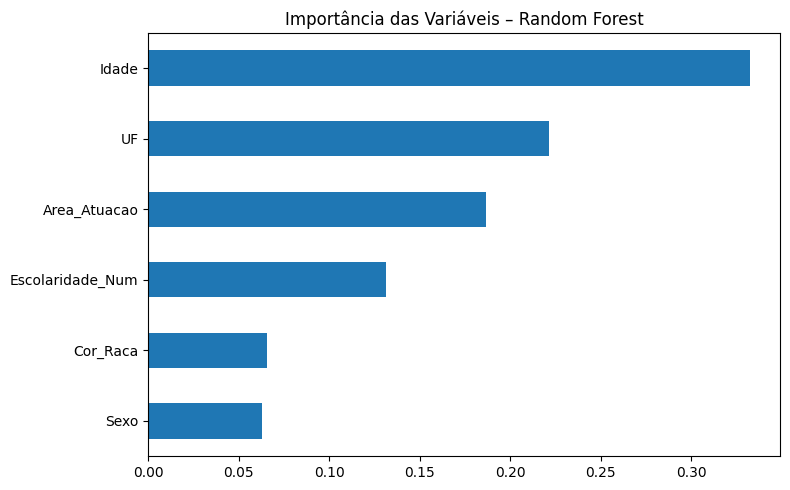

In [8]:
importancias = pd.Series(modelo_rf.feature_importances_, index=X.columns)
importancias.sort_values().plot(kind='barh', figsize=(8, 5))
plt.title('Importância das Variáveis – Random Forest')
plt.tight_layout()
plt.show()


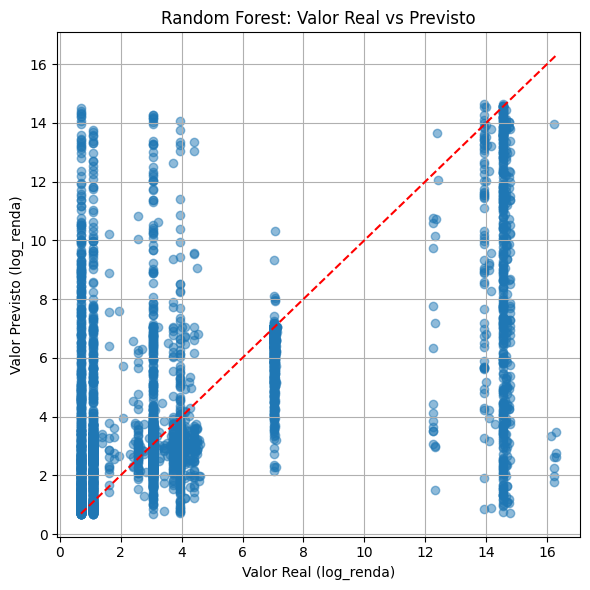

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real (log_renda)")
plt.ylabel("Valor Previsto (log_renda)")
plt.title("Random Forest: Valor Real vs Previsto")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Adiciona previsões ao DataFrame de teste
df_resultados = X_test.copy()
df_resultados['log_renda_real'] = y_test
df_resultados['log_renda_prevista'] = y_pred_rf

# Exporta para CSV se quiser analisar no Excel ou Power BI
df_resultados.to_csv("resultados_ml/resultados_random_forest.csv", index=False)


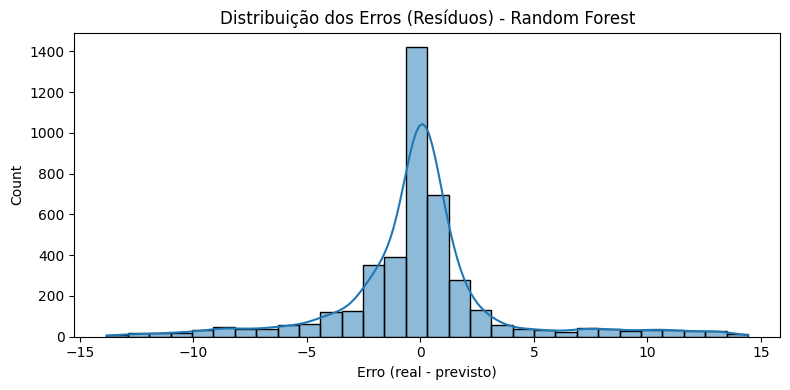

In [11]:
residuos = y_test - y_pred_rf

plt.figure(figsize=(8, 4))
sns.histplot(residuos, bins=30, kde=True)
plt.title("Distribuição dos Erros (Resíduos) - Random Forest")
plt.xlabel("Erro (real - previsto)")
plt.tight_layout()
plt.show()


In [12]:
df_resultados['erro_absoluto'] = abs(df_resultados['log_renda_real'] - df_resultados['log_renda_prevista'])
top_erros = df_resultados.sort_values(by='erro_absoluto', ascending=False).head(10)
display(top_erros)


,Idade,Escolaridade_Num,Sexo,Cor_Raca,UF,Area_Atuacao,log_renda_real,log_renda_prevista,erro_absoluto
20859,25,9.319763,0,3,6,2,16.213406,1.786841,14.426565
438,31,10.000000,1,3,21,2,16.213406,1.977975,14.235431
19515,19,9.319763,1,3,10,5,14.779109,0.717475,14.061634
14158,49,7.000000,0,4,12,2,16.213406,2.238470,13.974937
5527,62,7.000000,1,1,26,5,0.693147,14.514436,13.821289
4941,44,7.000000,0,4,26,5,14.567451,0.749098,13.818352
17783,41,10.000000,1,1,23,5,0.693147,14.410965,13.717818
5081,34,12.000000,0,1,26,2,16.300418,2.609657,13.690761
6328,22,7.000000,0,3,9,5,14.740242,1.055067,13.685175
1805,58,7.000000,1,3,3,5,0.693147,14.327228,13.634081


In [13]:
# Colunas categóricas
cat_cols = ['Sexo', 'Cor_Raca', 'UF', 'Setor_Economico', 'Area_Atuacao', 'Faixa_Etaria']

# Transformação
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ],
    remainder='passthrough'  # manter as variáveis numéricas como estão
)

# Aplicar na matriz X
X_encoded = preprocessor.fit_transform(df[cat_cols + ['Idade', 'Escolaridade_Num']])
y = df['log_renda']

In [14]:
# Imputar valores faltantes com a média (ou mediana, se preferir)
imputer = SimpleImputer(strategy='mean')
X_encoded_imputed = imputer.fit_transform(X_encoded)

In [15]:
# Train/test split com os dados imputados
X_train, X_test, y_train, y_test = train_test_split(X_encoded_imputed, y, test_size=0.2, random_state=42)

# Modelo
modelo_gb = GradientBoostingRegressor(random_state=42)
modelo_gb.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [16]:
# Previsão
y_pred_gb = modelo_gb.predict(X_test)

# Avaliação
print("R² (Gradient Boosting):", r2_score(y_test, y_pred_gb))
print("RMSE (Gradient Boosting):", np.sqrt(mean_squared_error(y_test, y_pred_gb)))


R² (Gradient Boosting): 0.3458463252930176
RMSE (Gradient Boosting): 3.5550728091611576


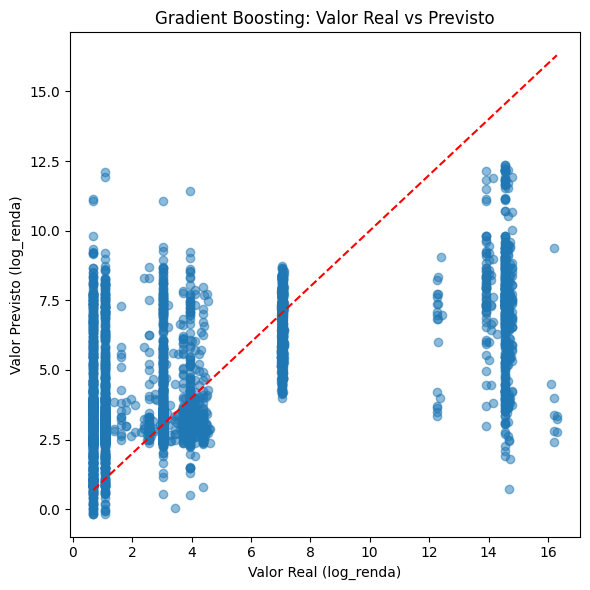

In [17]:

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real (log_renda)")
plt.ylabel("Valor Previsto (log_renda)")
plt.title("Gradient Boosting: Valor Real vs Previsto")
plt.tight_layout()
plt.show()


In [18]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Melhor modelo:", grid_search.best_params_)

# Avaliação do melhor modelo
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("R² (Melhor Modelo):", r2_score(y_test, y_pred_best))
print("RMSE (Melhor Modelo):", np.sqrt(mean_squared_error(y_test, y_pred_best)))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Melhor modelo: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
R² (Melhor Modelo): 0.3842539505538618
RMSE (Melhor Modelo): 3.449128892234505


In [19]:
modelo_xgb = XGBRegressor(random_state=42)
modelo_xgb.fit(X_train, y_train)
y_pred_xgb = modelo_xgb.predict(X_test)

print("R² (XGBoost):", r2_score(y_test, y_pred_xgb))
print("RMSE (XGBoost):", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


R² (XGBoost): 0.3728106925033663
RMSE (XGBoost): 3.4810313124485384


In [20]:
modelo_lgbm = LGBMRegressor(random_state=42)
modelo_lgbm.fit(X_train, y_train)
y_pred_lgbm = modelo_lgbm.predict(X_test)

print("R² (LightGBM):", r2_score(y_test, y_pred_lgbm))
print("RMSE (LightGBM):", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 16990, number of used features: 44
[LightGBM] [Info] Start training from score 4.599595
R² (LightGBM): 0.393307305865377
RMSE (LightGBM): 3.4236786102251666


/home/lucas/Documentos/tcc/devTCC/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [21]:
modelo_cat = CatBoostRegressor(verbose=0, random_state=42)
modelo_cat.fit(X_train, y_train)
y_pred_cat = modelo_cat.predict(X_test)

print("R² (CatBoost):", r2_score(y_test, y_pred_cat))
print("RMSE (CatBoost):", np.sqrt(mean_squared_error(y_test, y_pred_cat)))

R² (CatBoost): 0.3965197808185361
RMSE (CatBoost): 3.4146022854460965


In [22]:
# Criar DataFrame com valores reais e previstos
resultados_cat = pd.DataFrame({
    'Valor_Real_log': y_test,
    'Valor_Previsto_log': y_pred_cat
})

# Exportar para CSV
resultados_cat.to_csv('resultados_ml/resultados_catboost.csv', index=False)

In [23]:
# Dicionário de métricas
metricas_cat = {
    'R2': r2_score(y_test, y_pred_cat),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_cat))
}

# Salvar em JSON
with open('resultados_ml/metricas_catboost.json', 'w') as f:
    json.dump(metricas_cat, f, indent=4)

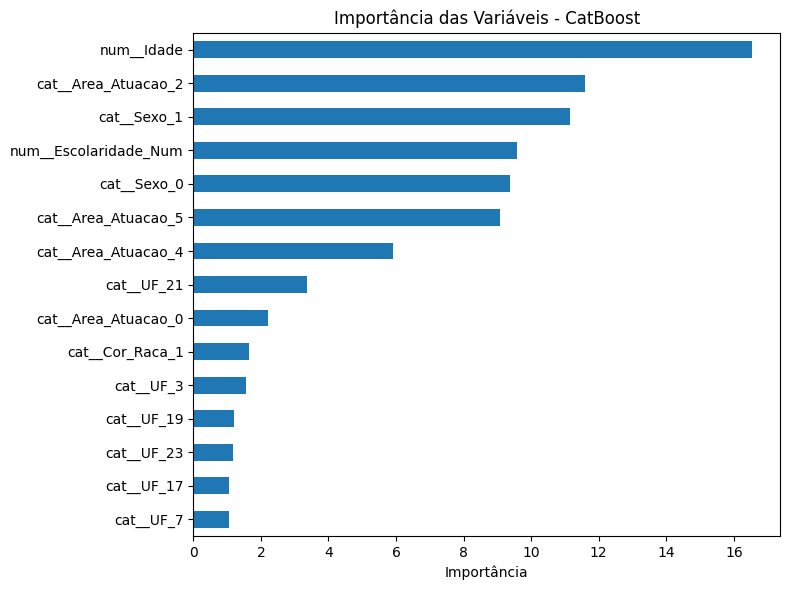

In [24]:
# 1. Definir as colunas categóricas + numéricas
cat_cols = ['Sexo', 'Cor_Raca', 'UF', 'Setor_Economico', 'Area_Atuacao', 'Faixa_Etaria']
num_cols = ['Idade', 'Escolaridade_Num']

# 2. Criar o pré-processador
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', SimpleImputer(strategy='mean'), num_cols)
])

# 3. Aplicar a transformação nos dados
X = df[cat_cols + num_cols]
y = df['log_renda']

X_encoded_imputed = preprocessor.fit_transform(X)

# 4. Obter os nomes das colunas transformadas
feature_names = preprocessor.get_feature_names_out(cat_cols + num_cols)

# 5. Transformar em DataFrame com nomes corretos
X_final_df = pd.DataFrame(X_encoded_imputed.toarray() if hasattr(X_encoded_imputed, 'toarray') else X_encoded_imputed,
                          columns=feature_names)

# 6. Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final_df, y, test_size=0.2, random_state=42)

# 7. Treinar modelo CatBoost
from catboost import CatBoostRegressor
modelo_cat = CatBoostRegressor(verbose=0, random_state=42)
modelo_cat.fit(X_train, y_train)

# 8. Importância das variáveis
importancias_cat = pd.Series(modelo_cat.get_feature_importance(), index=X_final_df.columns)

# 9. Exportar para CSV
importancias_cat.sort_values(ascending=False).to_csv('resultados_ml/importancia_variaveis_catboost.csv')

# 10. Visualização (opcional)
import matplotlib.pyplot as plt
importancias_cat.sort_values(ascending=False).head(15).plot(kind='barh', figsize=(8, 6))
plt.title('Importância das Variáveis - CatBoost')
plt.xlabel('Importância')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [25]:
# Consolidar os resultados
resultados_modelos = pd.DataFrame({
    'Modelo': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost'],
    'R²': [
        0.1308,
        0.2806,
        0.3458,
        0.3728,
        0.3933,
        0.3965
    ],
    'RMSE': [
        4.0979,
        3.7281,
        3.5551,
        3.4810,
        3.4236,
        3.4146
    ]
})

# Visualizar
print(resultados_modelos)

# Exportar se quiser
resultados_modelos.to_csv('resultados_ml/avaliacao_modelos.csv', index=False)

              Modelo      R²    RMSE
0  Linear Regression  0.1308  4.0979
1      Random Forest  0.2806  3.7281
2  Gradient Boosting  0.3458  3.5551
3            XGBoost  0.3728  3.4810
4           LightGBM  0.3933  3.4236
5           CatBoost  0.3965  3.4146


In [ ]:
# Exportar valores reais e previstos (CatBoost)
df_pred = pd.DataFrame({
    'Real (log_renda)': y_test,
    'Previsto (log_renda)': y_pred_cat
})

df_pred.to_csv('resultados_ml/predicoes_catboost.csv', index=False)
